# Classification Binary - Injuries - Models

In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from math import factorial, sqrt, fabs
import matplotlib.lines as mlines

import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import rv_discrete

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_recall_fscore_support
from sklearn.preprocessing import MinMaxScaler, scale

from collections import Counter, defaultdict
import random
random.seed(4444)

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
subset_trainvalid = pd.read_pickle('./dfs/subset_trainvalid')
subset_test = pd.read_pickle('./dfs/subset_test')

## Model features

In [3]:
features = ['INJURIES', 'DEATHS', 'INJURIES_YES', 'DEATHS_YES',  
            'EVENT_CATEGORY', 'SEASON', 'BEGIN_YEAR', 
             'LAT', 'LON', 'TOR_F_SCALE',
            'STATE']
            #'MAGNITUDE', 'CATEGORY', 'DURATION', 'BEGIN_RANGE'
            # 'WFO'
df_trainvalid = subset_trainvalid.loc[:,features]
df_test = subset_test.loc[:,features]
feat_cat = ['EVENT_CATEGORY', 'SEASON', 'BEGIN_YEAR', 'STATE', 'TOR_F_SCALE']
for item in feat_cat:
    df_trainvalid[item] = df_trainvalid[item].astype('category')
    df_test[item] = df_test[item].astype('category')

## Dividing data into training-valid sets

In [4]:
df_train, df_valid = train_test_split(df_trainvalid, test_size = 0.3)

# no missing values
#df_train = df_train.loc[ df_train.EVENT_CATEGORY.notnull(),:]
#l = 1.0*len(df_train)
#for name in df_train.columns.values:
#    ln = len(df_train[df_train[name].isnull()])
#    print name, ln/l

## Dummies for categorical variables

In [5]:
yinjuries_train = df_train['INJURIES_YES']
yinjuries_valid = df_valid['INJURIES_YES']
yinjuries_trainvalid = df_trainvalid['INJURIES_YES']
yinjuries_test = df_test['INJURIES_YES']
Xid_train = df_train.loc[:,'EVENT_CATEGORY':]
Xid_valid = df_valid.loc[:,'EVENT_CATEGORY':]
Xid_trainvalid = df_trainvalid.loc[:,'EVENT_CATEGORY':]
Xid_test = df_test.loc[:,'EVENT_CATEGORY':]
Xid_train = pd.get_dummies(Xid_train)
Xid_valid = pd.get_dummies(Xid_valid)
Xid_trainvalid = pd.get_dummies(Xid_trainvalid)
Xid_test = pd.get_dummies(Xid_test)
# Train set has very unbalanced INJURIES_YES: True - False groups
print yinjuries_train.value_counts()

0    610157
1      7440
Name: INJURIES_YES, dtype: int64


# Model

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

def mean_cross_val_score(estimator, X, y, cv=None, scoring=None, n_jobs=1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    scores_mean = np.mean(scores)
    return scores_mean

def baseline_predictor(y_train, n):
    labels = y_train.unique()
    return [Counter(y_train).most_common(1)[0][0]]*n

### Baseline predictor

In [7]:
yinjuries_predbp = baseline_predictor(yinjuries_train, len(Xid_valid))
print 'Baseline Predictor - Test accuracy:', 
print accuracy_score(yinjuries_valid, yinjuries_predbp),'\n'
print classification_report(yinjuries_valid, yinjuries_predbp),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predbp), '\n'

Baseline Predictor - Test accuracy: 0.988140619982 

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    261546
          1       0.00      0.00      0.00      3139

avg / total       0.98      0.99      0.98    264685


[[261546      0]
 [  3139      0]] 



/home/lucia/anaconda2/lib/python2.7/site-packages/scikit_learn-0.17.1-py2.7-linux-x86_64.egg/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC score:  0.5


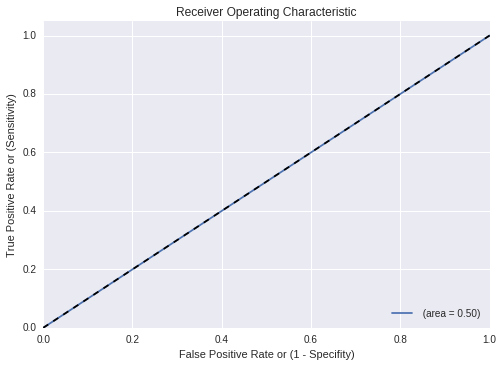

In [8]:
print 'AUC score: ', 
print roc_auc_score(yinjuries_valid, yinjuries_predbp)  
fpr, tpr, thresholds = roc_curve(yinjuries_valid, yinjuries_predbp)  
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [9]:
logrzw = LogisticRegression()
modelLRzw = logrzw.fit(Xid_train, yinjuries_train) 
yinjuries_predLRzw = logrzw.predict(Xid_valid)
aclrzw = accuracy_score(yinjuries_valid, yinjuries_predLRzw)
print 'Test accuracy for Logistic Regression:', aclrzw
print classification_report(yinjuries_valid, yinjuries_predLRzw),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predLRzw)

Test accuracy for Logistic Regression: 0.988257740333
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    261546
          1       0.58      0.03      0.06      3139

avg / total       0.98      0.99      0.98    264685


[[261469     77]
 [  3031    108]]


AUC score:  0.51705572923


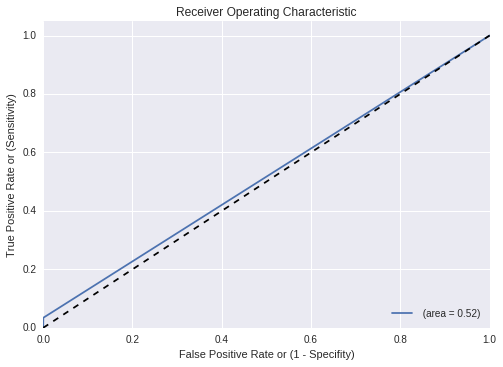

In [10]:
print 'AUC score: ', 
print roc_auc_score(yinjuries_valid, yinjuries_predLRzw)  
fpr, tpr, thresholds = roc_curve(yinjuries_valid, yinjuries_predLRzw)  
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Decision Tree and Random Forest

In [11]:
dtc = DecisionTreeClassifier(class_weight='balanced')
modeldtc = dtc.fit(Xid_train, yinjuries_train) 
yinjuries_predDTC = dtc.predict(Xid_valid)
acdtc = accuracy_score(yinjuries_valid, yinjuries_predDTC)
print 'Test accuracy for Decision Tree Classifier:', acdtc
#print "Mean accuracy for Decision Tree Classifier: ", mean_cross_val_score(dtc, X, y)
print classification_report(yinjuries_valid, yinjuries_predDTC),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predDTC)

Test accuracy for Decision Tree Classifier: 0.893888962351
             precision    recall  f1-score   support

          0       0.99      0.90      0.94    261546
          1       0.04      0.38      0.08      3139

avg / total       0.98      0.89      0.93    264685


[[235397  26149]
 [  1937   1202]]


In [12]:
rfczw = RandomForestClassifier()
modelrfczw = rfczw.fit(Xid_train, yinjuries_train) 
yinjuries_predRFzw = rfczw.predict(Xid_valid)
acrfczw = accuracy_score(yinjuries_valid, yinjuries_predRFzw)
print 'Test accuracy for Random Forest Classifier:', acrfczw
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yinjuries_valid, yinjuries_predRFzw),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predRFzw)

Test accuracy for Random Forest Classifier: 0.987415229424
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    261546
          1       0.34      0.06      0.11      3139

avg / total       0.98      0.99      0.98    264685


[[261151    395]
 [  2936    203]]


In [13]:
rfcd30 = RandomForestClassifier(max_depth=30)
modelrfcd30 = rfcd30.fit(Xid_train, yinjuries_train) 
yinjuries_predRFd30 = rfcd30.predict(Xid_valid)
acrfcd30 = accuracy_score(yinjuries_valid, yinjuries_predRFd30)
print 'Test accuracy for Random Forest Classifier:', acrfcd30
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yinjuries_valid, yinjuries_predRFd30),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predRFd30)

Test accuracy for Random Forest Classifier: 0.988057502314
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    261546
          1       0.47      0.05      0.10      3139

avg / total       0.98      0.99      0.98    264685


[[261358    188]
 [  2973    166]]


In [14]:
ada = AdaBoostClassifier()
modelada = ada.fit(Xid_train, yinjuries_train) 
yinjuries_predada = ada.predict(Xid_valid)
acada = accuracy_score(yinjuries_valid, yinjuries_predada)
print 'Test accuracy for AdaBoost Classifier:', acada
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yinjuries_valid, yinjuries_predada),'\n'
print confusion_matrix(yinjuries_valid, yinjuries_predada)

Test accuracy for AdaBoost Classifier: 0.988208625347
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    261546
          1       0.60      0.02      0.03      3139

avg / total       0.98      0.99      0.98    264685


[[261509     37]
 [  3084     55]]


AUC score:  0.526082140487


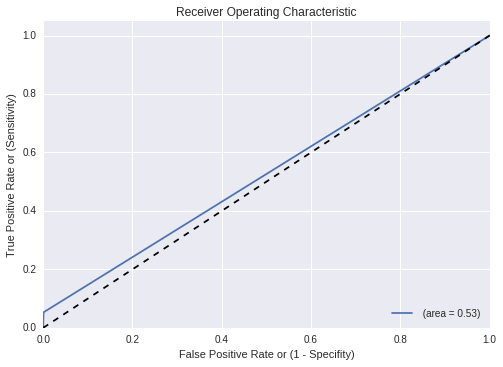

In [15]:
print 'AUC score: ', 
print roc_auc_score(yinjuries_valid, yinjuries_predRFd30)  
fpr, tpr, thresholds = roc_curve(yinjuries_valid, yinjuries_predRFd30) 
#print fpr, tpr
plt.plot(fpr, tpr, label=' (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Analyzing results

In [16]:
def get_prec_recall(model, X, y):
    proba = model.predict_proba(X)
    proba0 = []
    proba1 = []
    for item in proba:
        proba0.append(item[0])
        proba1.append(item[1])
    return (precision_recall_curve(y, proba0), precision_recall_curve(y, proba1))

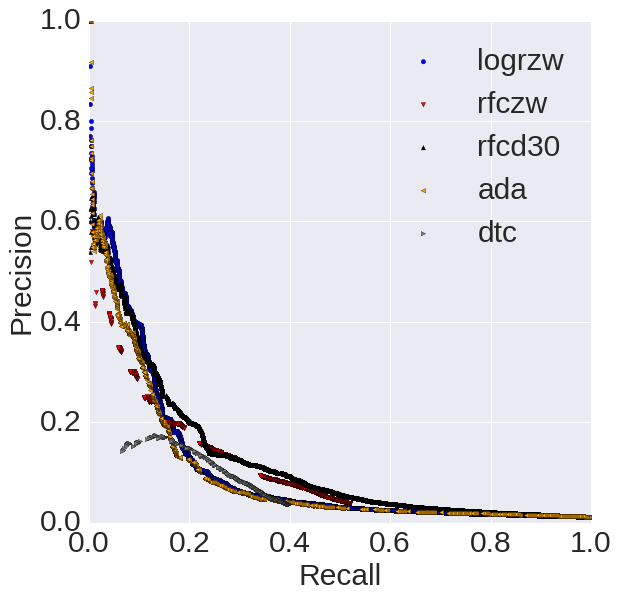

In [17]:
# All models: around 90% recall 2% precision
# MORE FEATURES NEEDED
# Here: use 90% recall data point to get new threshold and relabel data to 0 and 1 groups
# Use rfcd30 -- pruned random forest 
models = [logrzw, rfczw, rfcd30, ada, dtc ]
names = ['logrzw', 'rfczw', 'rfcd30', 'ada', 'dtc']
colors = ['blue', 'red', 'black', 'orange', 'grey']
sizes = [20]*len(models)
markers = ['o', 'v', '^', '<', '>', '*', 's', 'p', '8', 'h', 'H', 'D', 'd']

plt.clf()
plt.figure(figsize=(9,9))
i = 0
for model in models:
    X = Xid_valid
    prec_rec = get_prec_recall(model, X, yinjuries_valid)
    #precision0 = prec_rec[0][0]
    #recall0 = prec_rec[0][1]
    #thresholds0 = prec_rec[0][2]
    precision1 = prec_rec[1][0]
    recall1 = prec_rec[1][1]
    thresholds1 = prec_rec[1][2]
    plt.scatter(recall1, precision1, label = names[i], c=colors[i], s=sizes[i],\
                marker=markers[i])
    plt.xlabel("Recall", fontsize=30)
    plt.ylabel("Precision", fontsize = 30)
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    i += 1
plt.legend(loc='best', fontsize=30)
plt.savefig('./figs/injuries_models.png', format='png')
plt.show()

### Setting new threshold

In [18]:
# Pick two points on the graph for comparison: 'balance', 'recall'
prec_rec = get_prec_recall(rfcd30, Xid_valid, yinjuries_valid)
precision1 = prec_rec[1][0]
recall1 = prec_rec[1][1]
thresholds1 = prec_rec[1][2]
epsilonbalance = 0.005
indicesbalance = np.where( np.absolute(recall1 - 0.205) < epsilonbalance )[0]
epsilonrecall = 0.01
indicesrecall = np.where( np.absolute(recall1 - 0.91) < epsilonrecall )[0]
minimumbalance = np.min(recall1[indicesbalance])
minimumrecall = np.min(recall1[indicesrecall])
minindexbalance = np.where( recall1 == minimumbalance )[0][0]
minindexrecall = np.where( recall1 == minimumrecall )[0][0]
print precision1[minindexbalance], recall1[minindexbalance], thresholds1[minindexbalance]
print precision1[minindexrecall], recall1[minindexrecall], thresholds1[minindexrecall]

0.20096 0.200063714559 0.124612517608
0.0163734016234 0.900286715514 0.00397733238696


### Run Pruned Random Forest on Test Set

In [19]:
rfcd30test = RandomForestClassifier(max_depth=30)
modelrfcd30test = rfcd30test.fit(Xid_trainvalid, yinjuries_trainvalid) 
yinjuries_predRFd30test = rfcd30test.predict(Xid_test)
print 'Test accuracy for Random Forest Classifier:', \
accuracy_score(yinjuries_test, yinjuries_predRFd30test)
#print "Mean accuracy for Random Forest Classifier: ", mean_cross_val_score(rfc, X, y)
print classification_report(yinjuries_test, yinjuries_predRFd30test),'\n'
print confusion_matrix(yinjuries_test, yinjuries_predRFd30test)

Test accuracy for Random Forest Classifier: 0.987745442511
             precision    recall  f1-score   support

          0       0.99      1.00      0.99    217894
          1       0.46      0.06      0.11      2677

avg / total       0.98      0.99      0.98    220571


[[217700    194]
 [  2509    168]]


In [20]:
# Calculate predictions based on the two new thresholds given by the two prec-recall points
probarfcd30 = rfcd30test.predict_proba(Xid_test)
y_predrfc30_adjbalance = []
y_predrfc30_adjrecall = []
for probability in probarfcd30:
    if probability[1] >= thresholds1[minindexbalance]:
        y_predrfc30_adjbalance.append(1)
    else:
        y_predrfc30_adjbalance.append(0)
    if probability[1] >= thresholds1[minindexrecall]:
        y_predrfc30_adjrecall.append(1)
    else:
        y_predrfc30_adjrecall.append(0)
y_predrfc30_adjbalance = np.array(y_predrfc30_adjbalance)
y_predrfc30_adjrecall = np.array(y_predrfc30_adjrecall)

In [21]:
print 'Test accuracy for Adjusted Random Forest Classifier - Balance:'\
, accuracy_score(yinjuries_test, y_predrfc30_adjbalance)
print classification_report(yinjuries_test, y_predrfc30_adjbalance),'\n'
print confusion_matrix(yinjuries_test, y_predrfc30_adjbalance),'\n'
print 'Test accuracy for Adjusted Random Forest Classifier - Recall:'\
, accuracy_score(yinjuries_test, y_predrfc30_adjrecall)
print classification_report(yinjuries_test, y_predrfc30_adjrecall),'\n'
print confusion_matrix(yinjuries_test, y_predrfc30_adjrecall),'\n'

Test accuracy for Adjusted Random Forest Classifier - Balance: 0.98040993603
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    217894
          1       0.20      0.21      0.20      2677

avg / total       0.98      0.98      0.98    220571


[[215697   2197]
 [  2124    553]] 

Test accuracy for Adjusted Random Forest Classifier - Recall: 0.422154317657
             precision    recall  f1-score   support

          0       1.00      0.42      0.59    217894
          1       0.02      0.86      0.03      2677

avg / total       0.98      0.42      0.58    220571


[[ 90805 127089]
 [   367   2310]] 



In [22]:
def print_confusion_matrix_by_storm_test(y, figpath):
    y = np.array(y)
    correct_indices = []
    correct_indices.append((yinjuries_test == 0) & (y == 0))
    correct_indices.append((yinjuries_test == 1) & (y == 1))
    correct_indices.append((yinjuries_test == 0) & (y == 1))
    correct_indices.append((yinjuries_test == 1) & (y == 0))

    stormsums = defaultdict(list)
    storms = df_trainvalid.EVENT_CATEGORY.unique()
    for storm in storms:
        storm_label = 'EVENT_CATEGORY_' + storm
        total = 0
        for i in range(4):
            val = sum(Xid_test.loc[ correct_indices[i], storm_label])
            stormsums[i].append(val)
            total += val
        stormsums[4].append(total)

    correct_bystorm = []
    stormsums[4] = np.array(stormsums[4])
    for i in range(5):
        correct_bystorm.append(pd.Series( 1.0*np.array(stormsums[i])/stormsums[4], \
                                         index = storms ).sort_values())

    title = ['True Zero Predictions', 'True Nonzero Predictions', 'Nonzero Predictions Are False',\
            'Zero Predictions Are False']
    plt.figure(figsize=(45,20))
    for i in range(4):
        s = plt.subplot(2,2,i+1)
        correct_bystorm[i].plot(kind = 'barh', title=title[i], fontsize=40, color ='#63d297')
        s.set_title(s.get_title(), fontsize=50, ha='center')
    plt.savefig(figpath)
    plt.show()

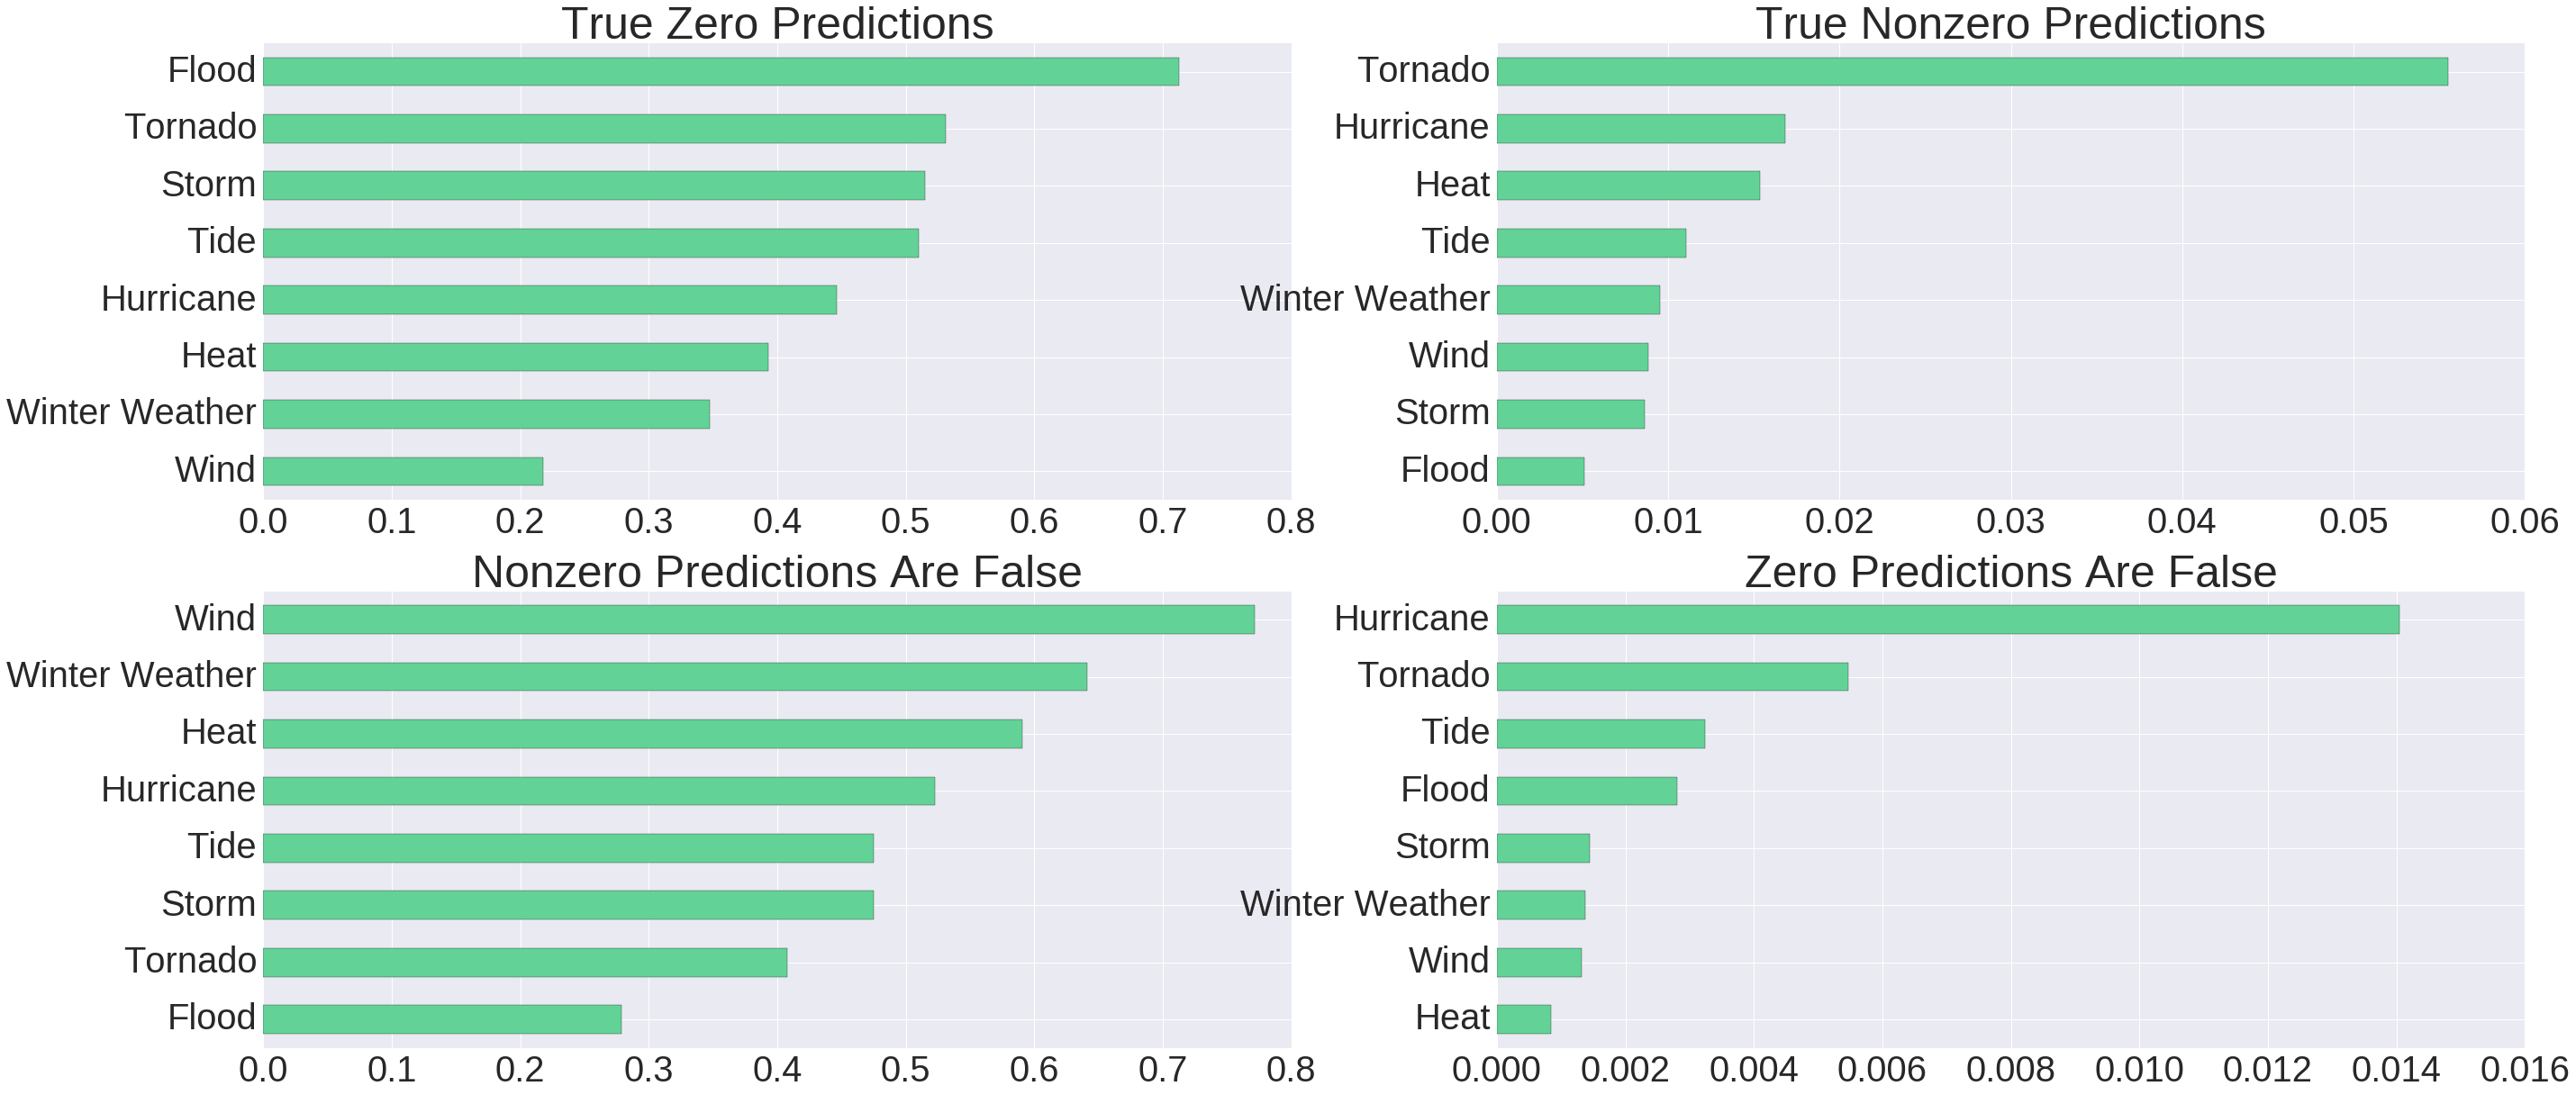

In [23]:
print_confusion_matrix_by_storm_test(y_predrfc30_adjrecall,
                                './figs/injuries_rf_accuracy_recall_test.png')

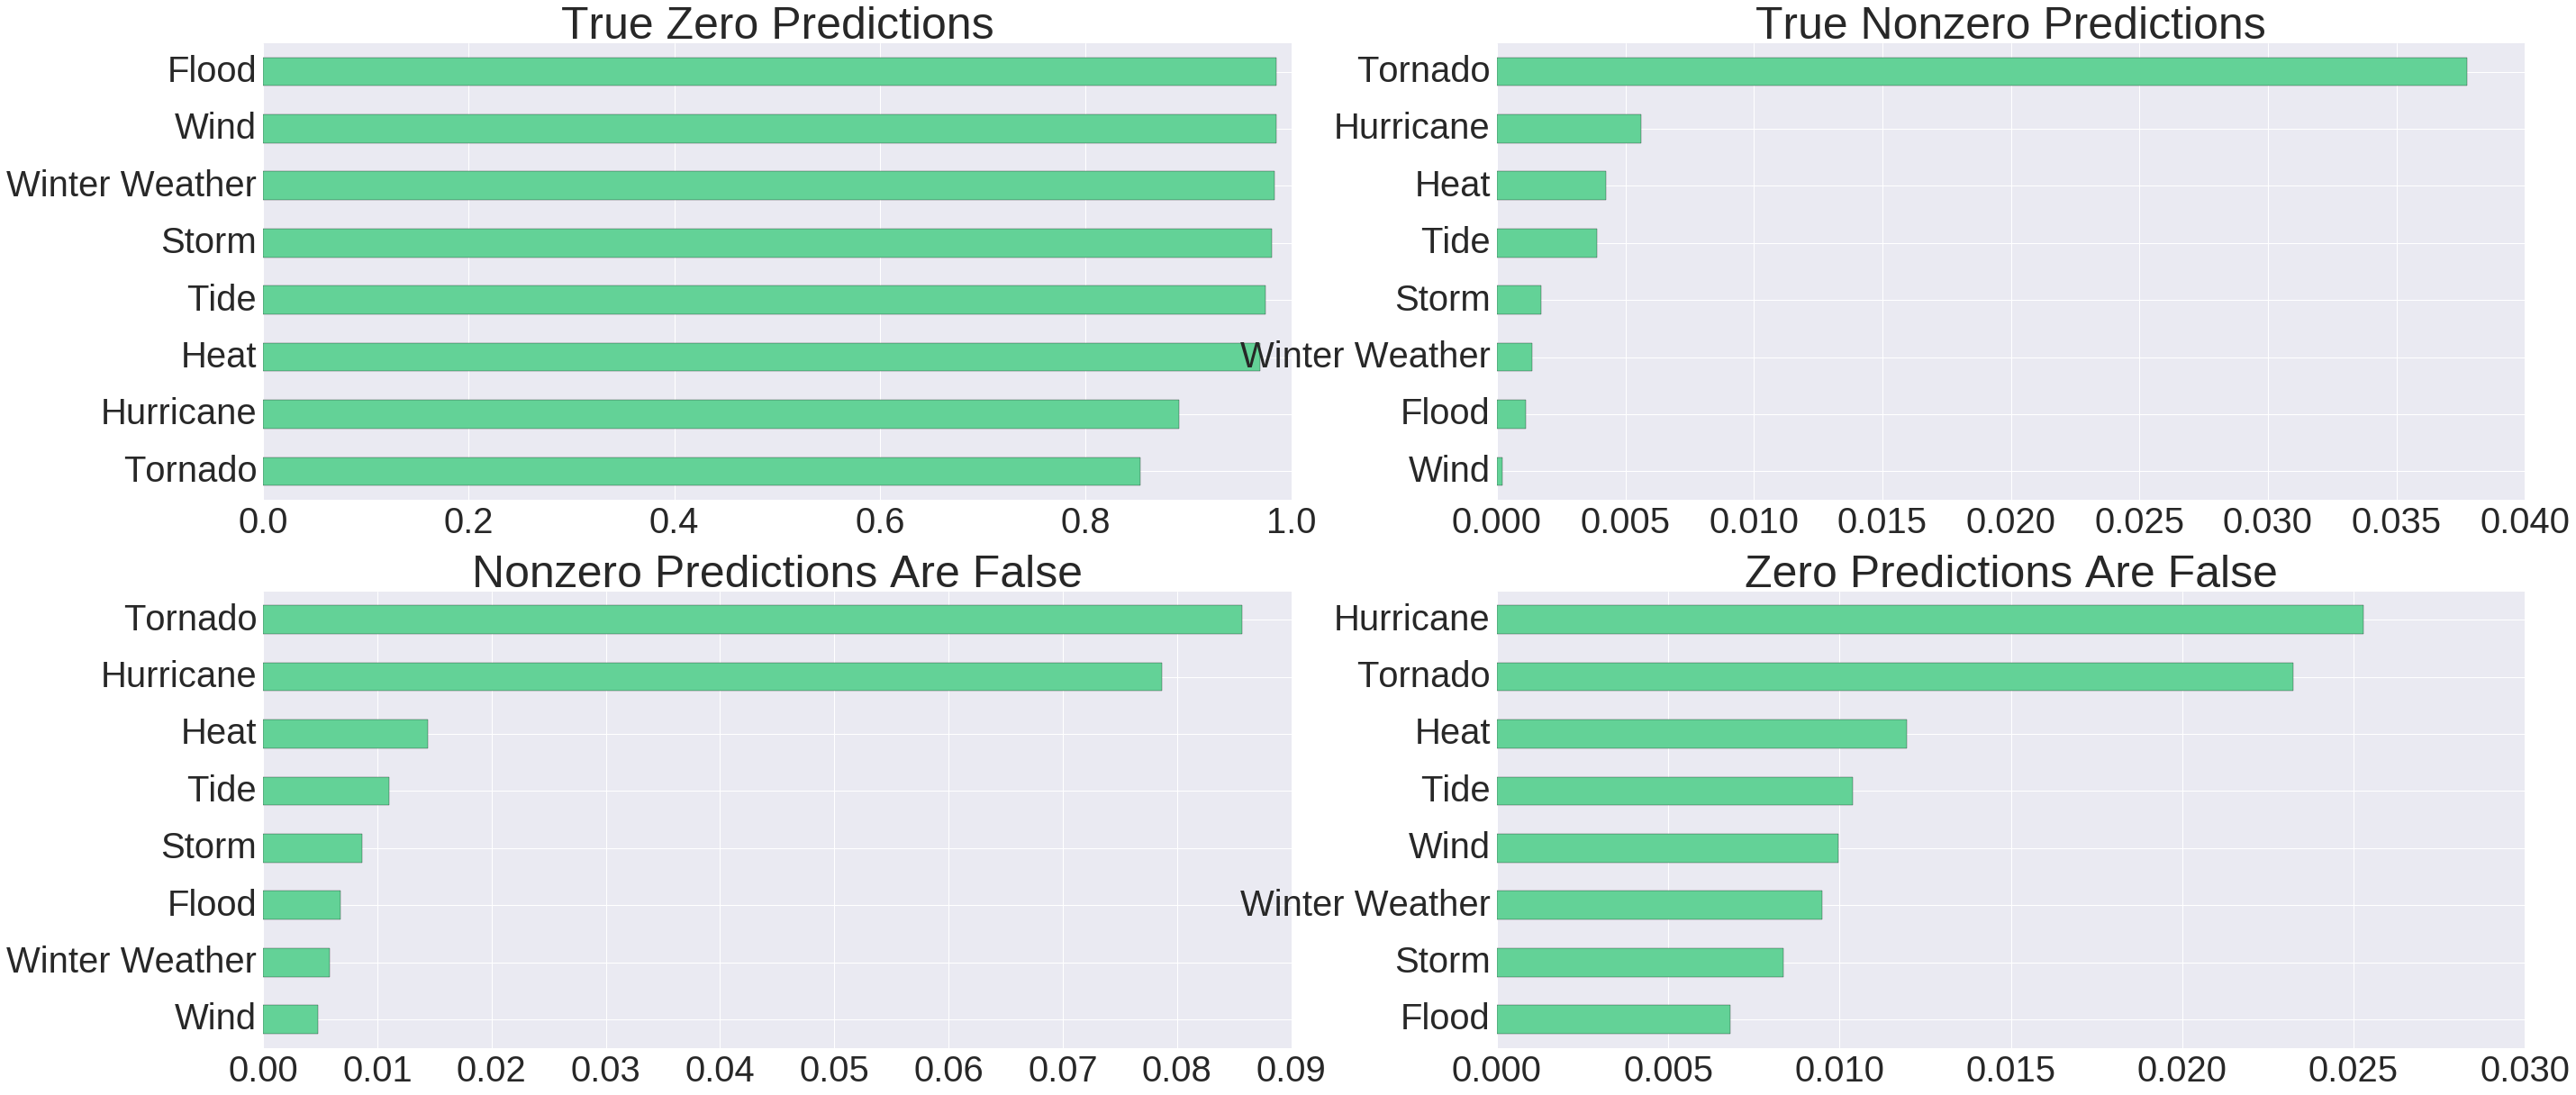

In [24]:
print_confusion_matrix_by_storm_test(y_predrfc30_adjbalance,
                                     './figs/injuries_rf_accuracy_balance_test.png')

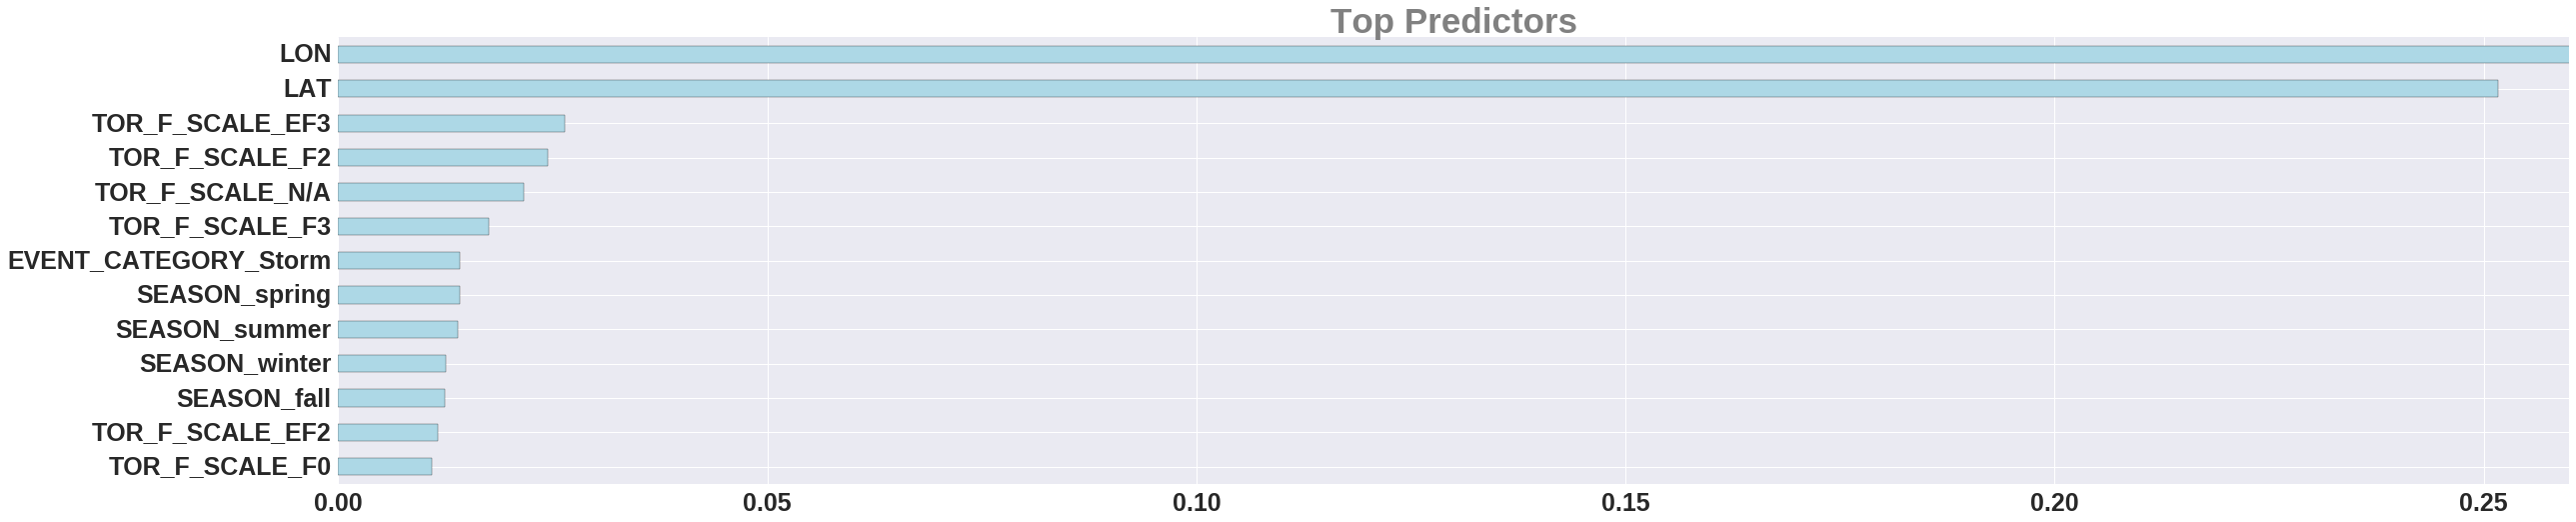

In [25]:
all_features = zip(Xid_test.columns.values, rfcd30test.feature_importances_)
all_features = sorted(all_features, key = lambda x: x[1], reverse=True)
top_features = pd.DataFrame(all_features[:13])
top_features.set_index([0], inplace = True)
top_features.sort_values(by=1, ascending=True, inplace=True)
del top_features.index.name

plt.close('all')
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rc('font', weight='bold')
plt.rcParams["figure.figsize"] = [40,8]
ax = top_features.plot(kind='barh', color ='lightblue',legend=False)
#ax.set_xlabel('Weight',fontsize=30)
#ax.set_ylabel('Predictor',fontsize=30)
ax.set_title('Top Predictors',fontsize=35, color='grey', fontweight='bold')
ax.set_xlim(0,0.26)
path = "./figs/injuries_rf_predictors_test.png"
plt.savefig(path)